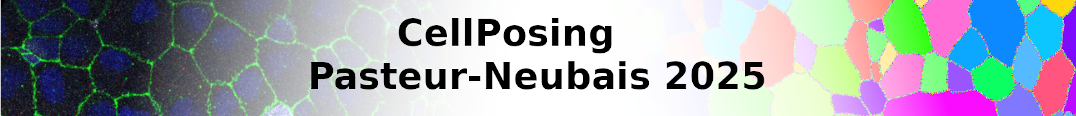
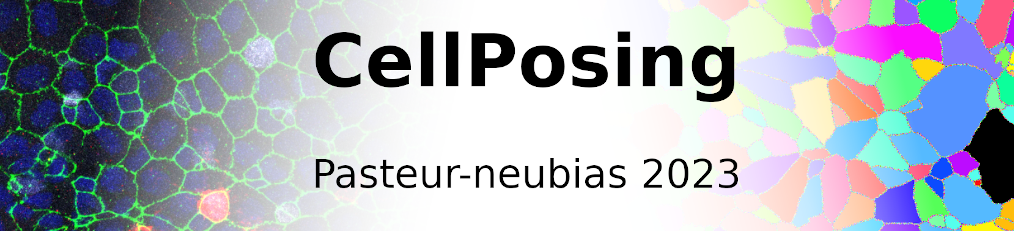

# CellPose overview

**Cellpose: a generalist algorithm for cellular segmentation** (2021)

Carsen Stringer, Tim Wang, Michalis Michaelos and Marius Pachitariu 

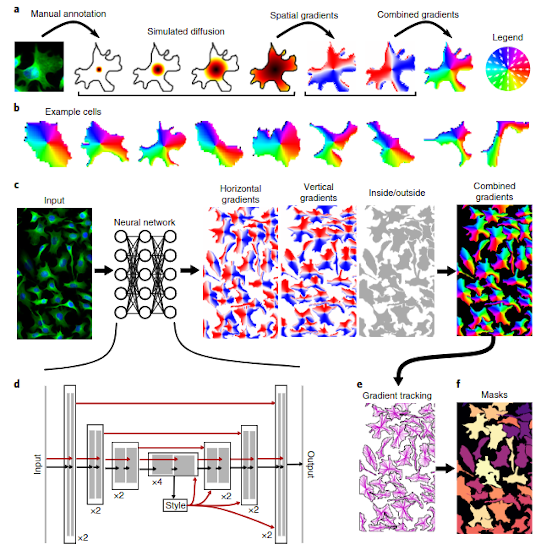
Figure 1 from CellPose paper.

**Strength of using the flow: non-convex shape and separating objects when dense images.**


* Main CellPose: https://www.cellpose.org/
* CellPose github: https://github.com/MouseLand/cellpose/tree/main
* Omnipose: http://www.cellpose.org/omnipose (for bacteria segmentation)

---

## CellPose versions

* CellPose 1: CellPose algorithm with flow computation
    * Cellpose: a generalist algorithm for cellular segmentation, *Carsen Stringer, Tim Wang, Michalis Michaelos & Marius Pachitariu* (2021) https://www.nature.com/articles/s41592-020-01018-x
* CellPose 2: add easy fine-tunning of models from the GUI
     * CellPose 2: Cellpose 2.0: how to train your own model, *Marius Pachitariu & Carsen Stringer* (2022)  https://www.nature.com/articles/s41592-022-01663-4
* CellPose 3: add denoising module for sub-optimal data
    * CellPose 3: Cellpose3: one-click image restoration for improved cellular segmentation, *Carsen Stringer, Marius Pachitariu* (2025) https://www.nature.com/articles/s41592-025-02595-5

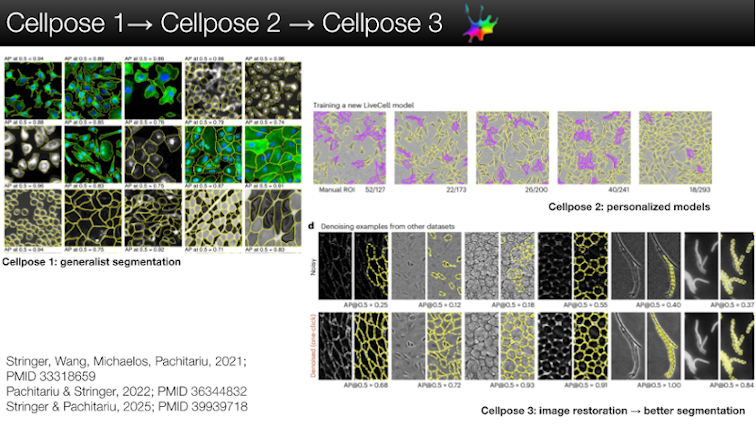
*From CellPose-SAM tutorial*

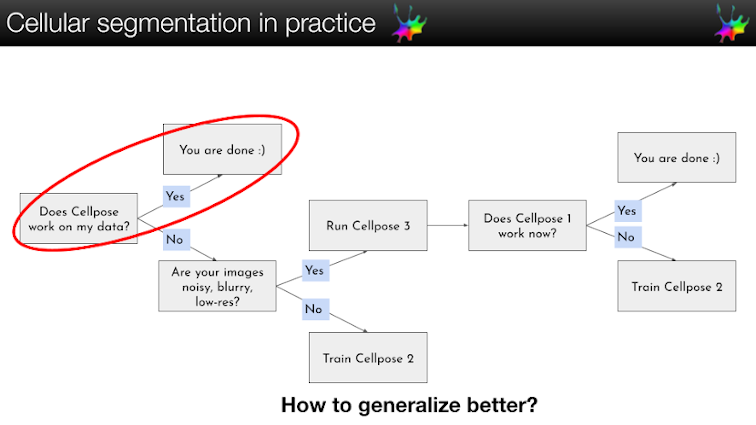
*From CellPose-SAM tutorial*

## New CellPose version !
Since ~10 days, a new version based on SAM is available
* CellPose-SAM: use SAM encoder (vision Transformer) to have a very generalisable model
    * CellPose-SAM (preprint): Cellpose-SAM: superhuman generalization for cellular segmentation, *Marius Pachitariu, Michael Rariden, Carsen Stringer* (2025) https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1
    * CellPose on hugging face: https://huggingface.co/spaces/mouseland/cellpose


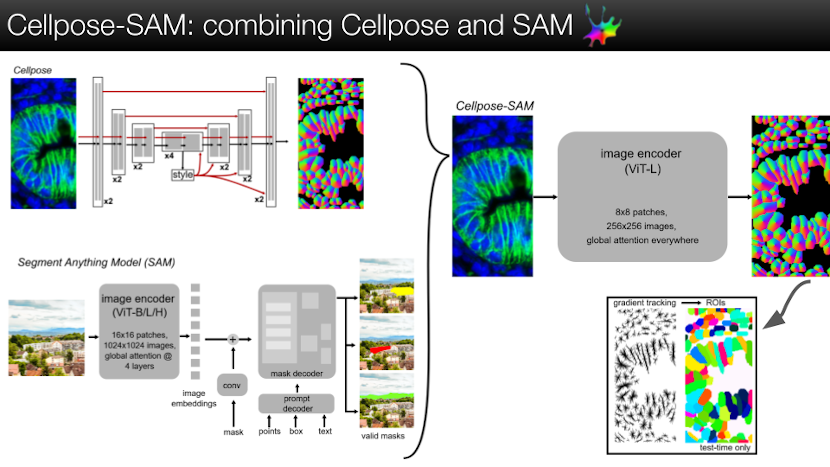
*From CellPose-SAM tutorial*

***
# Running CellPose 

There's a nice GUI to run it (install cellpose with `pip install cellpose[gui]` then run `python -m cellpose`.
You can easily correct the results and retrain from the GUI. 


It's also possible to run directly CellPose online from the website: https://www.cellpose.org/ and the new CellPose-SAM here: https://huggingface.co/spaces/mouseland/cellpose


We will use it from the Notebook in this course, but feel free to use the GUI if you prefer.
We will test the two different versions of CellPose, the "classic" versions (with the version 3) and the new "transformer" version with Cellpose-SAM

In [ ]:
## Imports
import os, shutil, random, time
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from glob import glob
import tempfile
import napari

## To test the new CellPose-SAM version
import cellpose as cellpose4
from cellpose import models as cp4_models

## The "classic" CellPose version (version 3)
import sys
sys.path.insert(1,os.path.abspath('src/cellpose3/'))
import src.cellpose3.cellpose as cellpose3
import src.cellpose3.cellpose.models as cp3_models
import src.cellpose3.cellpose.dynamics as cp3_dyn

### Check if GPU available

In [ ]:
use_GPU = cellpose3.core.use_gpu()
if use_GPU:
    print('use GPU')
else:
    print("no available GPU found. Will run on CPU")

## Datasets

- *cptest*: a subset from CellPose test dataset: https://www.cellpose.org/dataset, with ground-truth
- *deXtimg*: Epithelial images, no ground truth, from DeXtrusion dataset (https://zenodo.org/record/7586394)
- *testPattern*: 2 images of pair of cells on pattern, from Burute et al., 2017, no ground truth
- *nuclei3D*: 3D nuclei of C.elegans, from https://doi.org/10.5281/zenodo.5942575 (ground-truth in the zenodo repository)
- *brightfieldCells*: extraocular muscle stem cells cultured in wells, in transmitted light, from Di Girolamo et al. 2024 (https://journals.biologists.com/dev/article/151/4/dev202144/343118/Extraocular-muscle-stem-cells-exhibit-distinct)

The next cell defines two function: `load_dataset` and `show_random_images` for convenience for the rest of the notebook.
It also indicates the path to the main directory where all the data are: `datadir`. Set it to your dataset directoty

In [ ]:
## path to data 
datadir = "data"

## Functions to load a dataset and show random images

def load_dataset( dataset_name, ground_truth=False ):
    """ Load all the images from the chosen dataset """

    ## get the list of images and mask files in the test folder
    filenames = glob( os.path.join( datadir, dataset_name, "*.tif") )
    filenames += glob( os.path.join( datadir, dataset_name, "*.png") )
  
    ## load the files
    imgs = [ cellpose4.io.imread(fimg) for fimg in filenames ]
    
    gts = None
    if ground_truth:
        gtnames = [ os.path.join( datadir, dataset_name, "masks", os.path.basename(filename) ) for filename in filenames ]
        gts = [ cellpose3.io.imread(fimg) for fimg in gtnames ]
        
    shape = imgs[0].shape
    print("Images shape: "+str(shape))
    if len(shape)>2:
        chanel_axis = np.where( shape==np.min(shape) )[0][0]
        if chanel_axis != 0:
            old_imgs = imgs.copy()
            imgs = [ np.moveaxis( img, chanel_axis, 0 ) for img in old_imgs ]
    return imgs, filenames, gts


def show_random_images( imgs, filenames, nimgs ):
    """ Display randomly chosen images """
    nimgs = min( len(imgs), nimgs )
    exs = random.sample( range(len(imgs)), nimgs )
    plt.figure( figsize=(nimgs*1,4.5), dpi=250 )
    for ind, indimg in enumerate(exs):
        img = imgs[indimg]
        print(filenames[ind])
        if len(img.shape)>2:
            nchan = img.shape[0]
            for chan in range(nchan):
                plt.subplot(4,nimgs,ind+1+nimgs*chan)
                plt.imshow(img[chan])
                plt.axis('off')
        else:
            plt.subplot(1,nimgs,ind+1)
            plt.imshow(img)
            plt.axis('off')

---

# Run CellPose

First, let's have a look at the dataset to segment

In [ ]:
## Choose a dataset to look at
dataset_name = "deXtimg"

imgs, filenames, _ = load_dataset( dataset_name, ground_truth=False )

## Show examples of images in the dataset
nex = 6  ## number of displayed images
show_random_images( imgs, filenames, nex )

# CellPose models

CellPose models are downloaded from cellpose (or huggingface) websites when selected and placed in the Cellpose model directory. You can also place your own retrained models there, or use the full path when choosing another pretrained model.

In [ ]:
print( "CellPose model directory: "+str(cp3_models.MODEL_DIR) )

CellPose (until version 3) proposed several trained networks:
- 'cyto': first chanel is chanel to segment, second optional is nuclei
- 'nuclei': first chanel is chanel to segment (nuclei), second is 0
- 'cyto2', 'cyto3': trained with additional images compare to 'cyto'
- 'tissuenet': trained on the 'tissuenet" dataset, that have both cytoplasm and nuclei
- 'livecell': trained on the live cell dataset, which has only cytoplasm
- 'CP': since cellpose2.0 trained with mix of data of the previous databases
- 'cyto2_cp3', 'tissuenet_cp3', 'livecell_cp3', 'yeast_PhC_cp3', "yeast_BF_cp3", "bact_phase_cp3", "bact_fluor_cp3", "deepbacs_cp3", "neurips_grayscale_cyto2",
"TN1", "TN2", "TN3", "LC1", "LC2", "LC3", "LC4", "neurips_cellpose_default", "neurips_cellpose_transformer": more specifics
- you can use your own model (e.g. a retrained one) by providing the full path to the model

With version 4, you cannot use the previous networks (not the same backbone). The new networks are:
- 'Cpsam': latest model, based on SAM encoder, supposed to be more generalisable
- you can use your own model (e.g. a retrained one) by providing the full path to the model

### Channels parameter:
2 parameters: channel to segment and the optional nuclei channel
- 0 for greyscale image, 1 for red, 2 green and 3 blue
- 0 if not second chanel, 1 red, 2 green, 3 blue

In [ ]:
## Choose a dataset to use
dataset_name = "deXtimg"
imgs, filenames, _ = load_dataset( dataset_name, ground_truth=False )
## Show examples of images in the dataset
nex = 5  ## number of displayed images
show_random_images( imgs, filenames, nex )

In [ ]:
# Load one of cellpose model
model = cp3_models.CellposeModel( gpu=use_GPU, model_type='cyto')

In [ ]:
print(model.pretrained_model)
model.net

In [ ]:
# Run model on test images
chancyto = 0  ## channel to segment, green (2)
channuc = 0  ## chanel of nuclei 0: none. 3: blue chanel
use_channels = [chancyto, channuc]

start_time = time.time()
masks, flows, styles = model.eval( imgs, channels=use_channels )
end_time = time.time()
print('Execution time:', end_time-start_time, 'seconds')

In [ ]:
# Display results, choose random image

nimgs = 3
rand_imgs = random.sample( range(len(imgs)), nimgs )
for rind in rand_imgs:
    print( filenames[rind] )
    fig = plt.figure(figsize=(5,1.5), dpi=200)
    cellpose3.plot.show_segmentation(fig, imgs[rind], masks[rind], flows[rind][0], channels=use_channels)
    plt.tight_layout()
    plt.show()


**Change the CellPose model in the code above to see the differences of output and/or the dataset**


---

## CellPose parameters

The `cellprob_threshold` determines proability that a detected object is a cell. The default is 0.0. The range of probability varies from -6 to 6.
Decrease this threshold if cellpose is not returning as many masks as you’d expect or if masks are too small.
Increase this threshold if cellpose is returning too many masks esp from dull/dim areas.

The `flow_threshold` parameter is the maximum allowed error of the flows for each mask. The default is 0.4.
Increase this threshold if cellpose is not returning as many masks as you’d expect.
Decrease this threshold if cellpose is returning too many ill-shaped masks.

`max_size_fraction` keeps only masks which size is less than the max_size_fraction of the image. Default is 0.4. If you have an image with only one big cell taking most of the image, you want to increase this parameter.


### Cell diameter

All CellPose models have been trained with images rescaled such that a cell is around 30 pixels diameter. 
Thus, images to run through CP has to be rescaled to match this scale. 
The parameter `diameter` in `eval` set the mean diameter (in pixels) of a cell in the image to segment.
If set to `None`, CP tries to estimate the cell diameter.

After determining the flows (dX, dY, cellprob) with the neural network, the model runs the dynamics. The dynamics can be run:

- at the rescaled size (`resample=False`). Will find more ROIs when the cells are small but will be slower in this case

- on the resampled, interpolated flows at the true image size (`resample=True`). Create smoother ROIs when the cells are large but will be slower in case

**Test the effect of these parameter on a test dataset**

Play around with `cellprob_threshold`, `flow_threshold`, `resample` and `diameter` parameters

In [ ]:
# Load the test files
imgs, filenames, _ = load_dataset( "testPattern", ground_truth=False )
show_random_images( imgs, filenames, 2 )

In [ ]:
chancyto = 2  ## channel to segment: grayscale
channuc = 3 ## no nuclei

# Choose model 
model = cp3_models.CellposeModel( gpu=use_GPU, model_type='cyto3' )

# Run cellpose
start_time = time.time()
masks, flows, styles = model.eval( imgs, channels=[chancyto, channuc], 
                                  diameter=30, 
                                  resample=False, 
                                  flow_threshold=0.5, 
                                  cellprob_threshold=0.0,
                                 )
end_time = time.time()
print('Execution time:', end_time-start_time, 'seconds')

# Display results
nimgs = 2 ## number of images to show
rand_imgs = random.sample( range(len(imgs)), nimgs )
for rind in rand_imgs:
    print( filenames[rind] )
    fig = plt.figure(figsize=(4,2), dpi=200)
    cellpose3.plot.show_segmentation(fig, imgs[rind], masks[rind], flows[rind][0], channels=[chancyto, channuc])
    plt.tight_layout()
    plt.show()

## Cell diameter parameter

In [ ]:
## load and show data
diam_file =  os.path.join( datadir, "circles.png" ) 
diam_img = cellpose4.io.imread( diam_file )

fig = plt.figure(dpi=50)
plt.imshow(diam_img)

In [ ]:
# Choose model 
model = cp3_models.CellposeModel( gpu=use_GPU, model_type='cyto3' )
use_channels = [0,0]

# Run cellpose
start_time = time.time()
mask, flow, style = model.eval( diam_img, channels=use_channels, diameter=30)
end_time = time.time()
print('Execution time:', end_time-start_time, 'seconds')

# Display results
fig = plt.figure(figsize=(4,1), dpi=200)
cellpose3.plot.show_segmentation(fig, diam_img, mask, flow[0], channels=use_channels)
plt.tight_layout()
plt.show()


**Find a good diameter to have all or nearly all the circles**


***

## CellPose-SAM size invariance

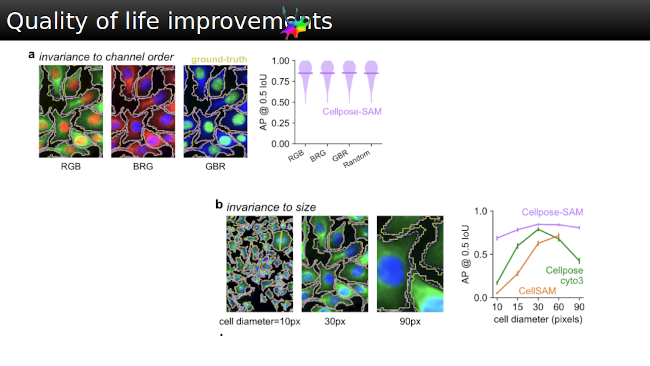

In [ ]:
## Test with CellPose-SAM

# Choose model 
cp4model = cp4_models.CellposeModel( gpu=use_GPU )

# Run cellpose
start_time = time.time()
mask, flow, style = cp4model.eval( diam_img )
end_time = time.time()
print('Execution time:', end_time-start_time, 'seconds')

# Display results
fig = plt.figure(figsize=(4,1), dpi=200)
cellpose4.plot.show_segmentation(fig, diam_img, mask, flow[0], channels=use_channels)
plt.tight_layout()
plt.show()

Note from CellPose documentation:
*Cellpose-SAM been trained on images with ROI diameters from size 7.5 to 120, with a mean diameter of 30 pixels.* 


In [ ]:
print(cp4model.net)

---

### CellPose-SAM generalisation

Let's run cellpose3 on brightfield images, then compare it with Cellpose-SAM

In [ ]:
# Load the test files
imgs, filenames, _ = load_dataset( "brightfieldCells", ground_truth=False )

show_random_images( imgs, filenames, 4 )

chancyto = 0  ## channel to segment: green (2)
channuc = 0 ## chanel of nuclei 0: none. 1: red

In [ ]:
# Choose model 
model = cp3_models.CellposeModel( gpu=use_GPU, model_type='livecell_cp3' )

# Run cellpose
start_time = time.time()
masks, flows, styles = model.eval( imgs, channels=[chancyto, channuc], 
                                  diameter=40, 
                                  resample=False, 
                                  flow_threshold=0.0, 
                                  cellprob_threshold=-6.0
                                 )
end_time = time.time()
print('Execution time:', end_time-start_time, 'seconds')

# Display results
nimgs = 2 ## number of images to show
rand_imgs = random.sample( range(len(imgs)), nimgs )
for rind in rand_imgs:
    print( filenames[rind] )
    fig = plt.figure(figsize=(4,1), dpi=200)
    cellpose3.plot.show_segmentation(fig, imgs[rind], masks[rind], flows[rind][0], channels=[chancyto, channuc])
    plt.tight_layout()
    plt.show()

**Now, try it with CellPose-SAM**

---

# Measure performances

If you have a ground-truth associated with a dataset, CellPose offers a function to evaluate the performance of the final segmentation.
The precision and recall of the labelled image are assessed by considering that masks are corresponding if they have an Intersection Over Union score above a given threshold.

Let's now use the `cptest` dataset that has a ground-truth to test the segmentation performance of CellPose3 cyto3 model and CellPose-SAM model.

We can also compare the memory and carbon emission that both models required when running. To evaluate carbon cost, we use the python module froom codecarbon.io (https://codecarbon.io/)

In [ ]:
## To track memory and carbon emissions of running jobs
from memory_profiler import memory_usage
from codecarbon import EmissionsTracker

In [ ]:
imgs, filenames, gts = load_dataset( "cptest", ground_truth=True )
show_random_images( imgs, filenames, 5 )

In [ ]:
# Run model on test images
chancyto = 0  ## channel to segment
channuc = 0  ## chanel of nuclei 0: none. 3: blue chanel
use_channels = [chancyto, channuc]

def run_cellpose():
    model = cp3_models.CellposeModel( gpu=use_GPU, model_type='cyto3' )
    masks, flows, styles = model.eval( imgs, channels=use_channels )
    print( "Evaluate performance on "+str(len(masks))+" images" )
    
    # Check performance using ground truth labels
    ap = cellpose4.metrics.average_precision(gts, masks)[0]
    print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')
    print(f'>>> average precision at iou threshold 0.9 = {ap[:,2].mean():.3f}')

tracker = EmissionsTracker(output_dir='./', measure_power_secs=60)
tracker.offline = True
tracker.country_iso_code = "FRA"
tracker.start()
start_time = time.time()
mem_usage = memory_usage(run_cellpose)
emissions: float = tracker.stop()
print("Emissions in C02eq (g): "+str(emissions*1000))
print('Maximum memory usage: %s' % max(mem_usage))
end_time = time.time()
print('Execution time:', end_time-start_time, 'seconds')
del tracker

In [ ]:
#### CellPose-SAM performance

def run_cellpose4():
    cp4model = cp4_models.CellposeModel( gpu=use_GPU )
    masks, flows, styles = cp4model.eval( imgs )
    print( "Evaluate performance on "+str(len(masks))+" images" )
    
    # Check performance using ground truth labels
    ap = cellpose4.metrics.average_precision(gts, masks)[0]
    print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')
    print(f'>>> average precision at iou threshold 0.9 = {ap[:,2].mean():.3f}')

tracker = EmissionsTracker(output_dir='./', measure_power_secs=60)
tracker.offline = True
tracker.country_iso_code = "FRA"
tracker.start()
start_time = time.time()
mem_usage = memory_usage(run_cellpose4)
emissions: float = tracker.stop()
print("Emissions in C02eq (g): "+str(emissions*1000))
print('Maximum memory usage: %s' % max(mem_usage))
end_time = time.time()
print('Execution time:', end_time-start_time, 'seconds')
del tracker

<hr style="border:4px solid gray">

# CellPose for spatial omics data

When nuclei/cytoplasm/membrane stainings have been done for the same slides as the spatial omics measures, after registering them (Marvin's course) you can use these staining to determine the cell contours and counts the corresponding genes inside each cells.

Let's now use a subset of the xenium dataset: we are using the Public data set from 10xGenomics
https://www.10xgenomics.com/datasets/ffpe-human-pancreas-with-xenium-multimodal-cell-segmentation-1-standard
The data are cropped from the *morphology_focus_0001.tif* file.

In [ ]:
# Load the test files
imgs, filenames, _ = load_dataset( "xenium_rois", ground_truth=False )
show_random_images( imgs, filenames, 4 )

The first channel is nuclei staining, the three others seem to be cytoplasmic stainings.
We combine them together in one channel to increase cytoplasmic staining.

In [ ]:
old_imgs = imgs.copy()
imgs = [ np.stack((img[1:].sum(axis=0), img[0]), axis=0) for img in old_imgs ]
show_random_images( imgs, filenames, 4 )

In [ ]:
chancyto = 2  ## channel to segment: second channel
channuc = 1 ## chanel of nuclei: 1: first channel (red)

# Choose model 
model = cp3_models.CellposeModel( gpu=use_GPU, model_type='cyto3' )
#model = cp4_models.CellposeModel( gpu=use_GPU)


# Run cellpose
start_time = time.time()
masks, flows, styles = model.eval( imgs, channels=[chancyto, channuc], 
                                  diameter=50, 
                                  resample=False, 
                                  flow_threshold=0.0, 
                                  cellprob_threshold=-6.0
                                 )
end_time = time.time()
print('Execution time:', end_time-start_time, 'seconds')

In [ ]:
# Display results
nimgs = 2 ## number of images to show
rand_imgs = random.sample( range(len(imgs)), nimgs )
for rind in rand_imgs:
    print( filenames[rind] )
    fig = plt.figure(figsize=(4,2), dpi=150)
    cellpose3.plot.show_segmentation(fig, imgs[rind], masks[rind], flows[rind][0], channels=[chancyto, channuc])
    plt.tight_layout()
    plt.show()
    ## show a zoom
    print("Zoom")
    x1 = 0
    x2 = 200
    y1 = 0
    y2 = 200
    fig = plt.figure(figsize=(3,1), dpi=200)
    cellpose3.plot.show_segmentation(fig, imgs[rind][:,x1:x2,y1:y2], masks[rind][x1:x2,y1:y2], flows[rind][0][x1:x2,y1:y2], channels=[chancyto, channuc])
    plt.tight_layout()
    plt.show()

***

# Big data computing

For large size images, CellPose can fail do to lack of memory. 

An extension of CP using overlapping blocks has been contributed by GFleishman. 
The code is on CP github: https://github.com/MouseLand/cellpose/blob/main/cellpose/contrib/distributed_segmentation.py

Documentation has now been added to CellPose doc: https://cellpose.readthedocs.io/en/latest/distributed.html

It uses *zarr* array that we saw in Marvin's course. It runs the CP networks in each chunks, and reconstruct each chunks dynamics. Then the masks from the chunks are stitched together to obtain the result mask. The flows and cell probs are not stitched together.

You can install, and import it with:
`!pip install cellpose[distributed]
from cellpose.contrib.distributed_segmentation import segment`

It has options to run on clusters (see the doc). **But it does not work on 2D images**


## 2D big data computing
Previously, ChrisRoat had contributed a first version of the distributed_segmentation file, that used *dask* for the distributed part (that we saw in Marvin's course).
Here I copy-pasted the file, and modified it with to be able to run it on **2D images** and set-up some parameters 

In [ ]:
"""Segments detected regions in a chunked dask array.

Uses overlapping chunks during segmentation, and determines how to link segments
between neighboring chunks by examining the overlapping border regions.

Heavily based on dask_image.ndmeasure.label, which uses non-overlapping blocks
with a structuring element that links segments at the chunk boundaries.

Copy-pasted and modified from: https://github.com/MouseLand/cellpose/blob/main/cellpose/contrib/distributed_segmentation.py (cellpose version 2)
Modified to use on 2D images and not recomputing all chunks
"""
import functools
import logging
import operator

import dask
import dask.array as da
import numpy as np

class DistSegError(Exception):
    """Error in image segmentation."""

try:
    from dask_image.ndmeasure._utils import _label
    from sklearn import metrics as sk_metrics
except ModuleNotFoundError as e:
    raise DistSegError("Install 'cellpose[distributed]' for distributed segmentation dependencies") from e


logger = logging.getLogger(__name__)


def dask_segment(
    image,
    channels,
    model_type,
    diameter,
    fast_mode=False,
    use_anisotropy=True,
    iou_depth=2,
    iou_threshold=0.7,
    chunksize = (1000,1000,1000,1),    ## add the chunksize parameter for the tests
    dim = 4, ## add the dimension parameter to do 2D images as well
    model = None, ## Added: cellpose model
    z_axis = None, ## which axis if 3D
    tmp_file=None, ## temporary directory where to store the computed chunks: Thanks Marvin for the idea !
):
    """Use cellpose to segment nuclei in fluorescence data.

    Parameters
    ----------
    image : array of shape (z, y, x, channel)
        Image used for detection of objects
    channels : array of int with size 2
        See cellpose
    model_type : str
        "cyto" or "nuclei"
    diameter : tuple of size 3
        Approximate diameter (in pixels) of a segmented region, i.e. cell width
    fast_mode : bool
        In fast mode, network averaging, tiling, and augmentation are turned off.
    use_anisotropy : bool
        If true, use anisotropy parameter of cellpose
    iou_depth: dask depth parameter
        Number of pixels of overlap to use in intersection-over-union calculation when
        linking segments across neighboring, overlapping dask chunk regions.
    iou_threshold: float
        Minimum intersection-over-union in neighboring, overlapping dask chunk regions
        to be considered the same segment.  The region for calculating IOU is given by the
        iou_depth parameter.

    Returns:
        segments : array of int32 with same shape as input
            Each segmented cell is assigned a number and all its pixels contain that value (0 is background)
    """
    #assert image.shape[-1] in {1, 2}, image.shape
    #assert diameter[1] == diameter[2], diameter

    diameter_yx = diameter[1]
    if dim == 4:
        anisotropy = diameter[0] / diameter[1] if use_anisotropy else None
    else:
        anisotropy = 1

    image = da.asarray(image, chunks=chunksize)  ## added the chunks parameter
    
    image = image.rechunk({-1: -1})  # color channel is chunked together

    depth = tuple(np.ceil(diameter).astype(np.int64))
    boundary = "reflect"

    # No chunking in channel direction
    image = da.overlap.overlap(image, depth + (0,), boundary)

    block_iter = zip(
        np.ndindex(*image.numblocks),
        map(
            functools.partial(operator.getitem, image),
            da.core.slices_from_chunks(image.chunks),
        ),
    )

    labeled_blocks = np.empty(image.numblocks[:-1], dtype=object)
    total = None
    for index, input_block in block_iter:
        labeled_block, n = dask.delayed(segment_chunk, nout=2)(
            input_block,
            channels,
            z_axis,
            model_type,
            diameter_yx,
            anisotropy,
            fast_mode,
            index,
            dim,
            model,
        )

        shape = input_block.shape[:-1]
        labeled_block = da.from_delayed(labeled_block, shape=shape, dtype=np.int32)

        #n = dask.delayed(np.int32)(n)
        n = da.from_delayed(n, shape=(), dtype=np.int32)

        total = n if total is None else total + n

        block_label_offset = da.where(labeled_block > 0, total, np.int32(0))
        labeled_block += block_label_offset

        labeled_blocks[index[:-1]] = labeled_block
        total += n

    # Put all the blocks together
    block_labeled = da.block(labeled_blocks.tolist())
    
    ## put the results of the chunks in a temporaray file, 
    ## otherwise it could recompute the chunks when doing the following function (post-processing to link the labels)
    ## Thanks Marvin for the idea !
    block_labeled = block_labeled.to_zarr(
       tmp_file,
       return_stored=True,
       compute=True,
       )  
    
    ## Post processing steps to link the labels between consecutives chunks using the overlaps
    depth = da.overlap.coerce_depth(len(depth), depth)

    if np.prod(block_labeled.numblocks) > 1:
        iou_depth = da.overlap.coerce_depth(len(depth), iou_depth)

        if any(iou_depth[ax] > depth[ax] for ax in depth.keys()):
            raise DistSegError("iou_depth (%s) > depth (%s)" % (iou_depth, depth))

        trim_depth = {k: depth[k] - iou_depth[k] for k in depth.keys()}
        block_labeled = da.overlap.trim_internal(
            block_labeled, trim_depth, boundary=boundary
        )
        block_labeled = link_labels(
            block_labeled,
            total,
            iou_depth,
            iou_threshold=iou_threshold,
        )

        block_labeled = da.overlap.trim_internal(
            block_labeled, iou_depth, boundary=boundary
        )

    else:
        block_labeled = da.overlap.trim_internal(
            block_labeled, depth, boundary=boundary
        )

    return block_labeled


def segment_chunk(
    chunk,
    channels,
    z_axis,
    model_type,
    diameter_yx,
    anisotropy,
    fast_mode,
    index,
    dim, 
    model,
):
    """Perform segmentation on an individual chunk."""
    # Cellpose seems to have some randomness, which is made deterministic by using the block
    # details as a random seed.
    np.random.seed(index)

    logger.info("Evaluating model")
    segments, _, _ = model.eval(
        chunk,
        channels=channels,
        z_axis=z_axis,
        channel_axis=dim-1,
        diameter=diameter_yx,
        do_3D=(dim==4),
        anisotropy=anisotropy,
        augment=not fast_mode,
    )
    logger.info("Done segmenting chunk")

    return segments.astype(np.int32), segments.max()


def link_labels(block_labeled, total, depth, iou_threshold=1):
    """
    Build a label connectivity graph that groups labels across blocks,
    use this graph to find connected components, and then relabel each
    block according to those.
    """
    label_groups = label_adjacency_graph(block_labeled, total, depth, iou_threshold)
    new_labeling = _label.connected_components_delayed(label_groups)
    return _label.relabel_blocks(block_labeled, new_labeling)


def label_adjacency_graph(labels, nlabels, depth, iou_threshold):
    all_mappings = [da.empty((2, 0), dtype=np.int32, chunks=1)]

    slices_and_axes = get_slices_and_axes(labels.chunks, labels.shape, depth)
    for face_slice, axis in slices_and_axes:
        face = labels[face_slice]
        mapped = _across_block_iou_delayed(face, axis, iou_threshold)
        all_mappings.append(mapped)

    i, j = da.concatenate(all_mappings, axis=1)
    result = _label._to_csr_matrix(i, j, nlabels + 1)
    return result


def _across_block_iou_delayed(face, axis, iou_threshold):
    """Delayed version of :func:`_across_block_label_grouping`."""
    _across_block_label_grouping_ = dask.delayed(_across_block_label_iou)
    grouped = _across_block_label_grouping_(face, axis, iou_threshold)
    return da.from_delayed(grouped, shape=(2, np.nan), dtype=np.int32)


def _across_block_label_iou(face, axis, iou_threshold):
    unique = np.unique(face)
    face0, face1 = np.split(face, 2, axis)

    intersection = sk_metrics.confusion_matrix(face0.reshape(-1), face1.reshape(-1))
    sum0 = intersection.sum(axis=0, keepdims=True)
    sum1 = intersection.sum(axis=1, keepdims=True)

    # Note that sum0 and sum1 broadcast to square matrix size.
    union = sum0 + sum1 - intersection

    # Ignore errors with divide by zero, which the np.where sets to zero.
    with np.errstate(divide="ignore", invalid="ignore"):
        iou = np.where(intersection > 0, intersection / union, 0)

    labels0, labels1 = np.nonzero(iou >= iou_threshold)

    labels0_orig = unique[labels0]
    labels1_orig = unique[labels1]
    grouped = np.stack([labels0_orig, labels1_orig])

    valid = np.all(grouped != 0, axis=0)  # Discard any mappings with bg pixels
    return grouped[:, valid]


def get_slices_and_axes(chunks, shape, depth):
    ndim = len(shape)
    depth = da.overlap.coerce_depth(ndim, depth)
    slices = da.core.slices_from_chunks(chunks)
    slices_and_axes = []
    for ax in range(ndim):
        for sl in slices:
            if sl[ax].stop == shape[ax]:
                continue
            slice_to_append = list(sl)
            slice_to_append[ax] = slice(
                sl[ax].stop - 2 * depth[ax], sl[ax].stop + 2 * depth[ax]
            )
            slices_and_axes.append((tuple(slice_to_append), ax))
    return slices_and_axes

In [ ]:
img = cellpose3.io.imread( os.path.join( datadir, "xeniumdata", "test.tif" ) )
print(img.shape)
vimg = img[0:2]
vimg = np.moveaxis( vimg, 0, 2 )
print(vimg.shape)

In [ ]:
#img = cellpose3.io.imread( os.path.join( datadir, "xeniumdata", "morphology_focus_0001_crop.tif" ) )

img = cellpose3.io.imread( os.path.join( datadir, "xeniumdata", "morphology_focus_0001_crop.tif" ) )
print(img.shape)
vimg = np.moveaxis( img, 0, 2 )
print(vimg.shape)

In [ ]:
cpmodel = cp3_models.CellposeModel( gpu=use_GPU, model_type="nuclei" )

# with CellPose-Dask
tmp_dir = tempfile.TemporaryDirectory()

dasky = dask_segment(
    vimg,
    channels=[1,0],
    model_type = 'nuclei',
    diameter=[30,30],
    fast_mode=True,
    use_anisotropy=True,
    iou_depth=10, #Number of pixels of overlap to use in IOU calculation when linking segments across neighboring, overlapping dask chunk regions.
    iou_threshold=0.5,
    chunksize=(1000,1000,3),  ## added parameter to be able to change it
    dim = 3, ## added parameter to use 2D cellpose as well
    model = cpmodel, ## added parameter to choose which cellpose model to use
    z_axis = None, ## precise which is the Z axis if 3D stack
    tmp_file = os.path.join(tmp_dir.name, "tmp.zarr"), ## temporary file to avoid re-computation of the chunks
    )
    
dasky

In [ ]:
start_time = time.time()
res = dasky.compute()
tmp_dir.cleanup()
end_time = time.time()
print('Execution time:', end_time-start_time, 'seconds')

In [ ]:
import napari

viewer = napari.Viewer()
viewer.add_image( img )
viewer.add_labels( res )
viewer.show()

## CellPose in 3D

CellPose doesn t really segment in 3D, but there are two 3D options:
- `do_3D` is False and `stitch_threshold`>0, CP segment in 2D and associate object in 3D if they overlap more than the threshold.
- `do_3D` run the image in xy, yz and xz and reconstruct the 3D objects from the combined flow maps.

In 3D mode, if the images are not isotropic in XY and Z, you should input the ratio of Z sampling compared to XY sampling in the `anisotropy` parameter.
anisotropy = 2.0 means Z is sampled half as dense as XY.

The `flow_threshold` is not used in 3D. Instead, nuclei can be removed if they are smaller than `min_size` (number of pixels in the mask).


**Run it first with CellPose3 version, then try it with CellPose4**

In [ ]:
nuc3D_img = cellpose3.io.imread( os.path.join(datadir, "nuclei3D", "eft3RW10035L1_0125071.tif") )
print(nuc3D_img.shape)
anisotropy = 0.122/0.116

In [ ]:
import napari

viewer = napari.Viewer()
viewer.add_image( nuc3D_img, scale=(0.116, 0.116, 0.122) )
viewer.show()

In [ ]:
start_time = time.time()

model = cp3_models.Cellpose(gpu=use_GPU, model_type="nuclei")
mask, flow, style, diam = model.eval(nuc3D_img, channels=[0,0], do_3D=True, diameter=20, stitch_threshold=0.6, anisotropy=anisotropy)

#model = cp4_models.CellposeModel(gpu=use_GPU)
#mask, flow, style= model.eval(nuc3D_img, channels=[0,0], do_3D=True, z_axis=0, anisotropy=anisotropy)

end_time = time.time()
print('Execution time:', end_time-start_time, 'seconds')

In [ ]:
viewer=napari.Viewer()
viewer.add_labels(mask, scale=(0.116,0.116,0.122), blending='additive')
viewer.add_image(nuc3D_img, scale=(0.116,0.116,0.122), blending='additive')
napari.run()

## 3D additional parameters

`flow3D_smooth` : if many cells are too fragmented, this parameter allows to smooth the flows in 3D before to run the dynamics. By default 0.0, no smoothing.

`normalize` (bool, optional): if True (deafult), normalize data so 0.0=1st percentile and 1.0=99th percentile of image intensities in each channel; 
                can also pass dictionary of parameters (all keys are optional, default values shown): 
* "lowhigh"=None : pass in normalization values for 0.0 and 1.0 as list [low, high] (if not None, all following parameters ignored)
* "sharpen"=0 ; sharpen image with high pass filter, recommended to be 1/4-1/8 diameter of cells in pixels
* "normalize"=True ; run normalization (if False, all following parameters ignored)
* "percentile"=None : pass in percentiles to use as list [perc_low, perc_high]
 * "tile_norm_blocksize"=0 ; compute normalization in tiles across image to brighten dark areas, to turn on set to window size in pixels (e.g. 100)
 * "norm3D"=True ; compute normalization across entire z-stack rather than plane-by-plane in stitching mode.
 

In [ ]:
## load the data
nuc3D_img = cellpose3.io.imread( os.path.join(datadir, "nuclei3D", "eft3RW10035L1_0125071_ex.tif") )
print(nuc3D_img.shape)
anisotropy = 0.122/0.116

## run cellpose
model = cp3_models.CellposeModel(gpu=use_GPU, model_type="nuclei")
mask, flow, style= model.eval(nuc3D_img, channels=[0,0], do_3D=True, z_axis=0, anisotropy=anisotropy )

In [ ]:
viewer=napari.Viewer()
viewer.add_labels(mask, scale=(0.116,0.116,0.122), blending='additive')
viewer.add_image(nuc3D_img, scale=(0.116,0.116,0.122), blending='additive')
napari.run()

In [ ]:
## Changing the parameters

mask, flow, style= model.eval(nuc3D_img, channels=[0,0], do_3D=True, z_axis=0, anisotropy=anisotropy, 
                              diameter=20, 
                              cellprob_threshold=-6.0, 
                              flow3D_smooth=20.0, 
                              normalize = {"normalize":True, "tile_norm_blocksize":100} )

In [ ]:
viewer=napari.Viewer()
viewer.add_labels(mask, scale=(0.116,0.116,0.122), blending='additive')
viewer.add_image(nuc3D_img, scale=(0.116,0.116,0.122), blending='additive')
napari.run()